# Elastic Search REST Queries

In [1]:
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt

## Docker ES

In [5]:
es_url1 = 'http://es-test:9200/{0}'
es_resource1 = 'landgrid/_search'

headers = {
            'Content-Type': 'application/json',
            'Cache-Control': 'no-cache'
        }

In [6]:
url = es_url1.format(es_resource1)
payload = {
  "aggregations" : {
      "no county" : {
          "missing" : { 
            "field" : "Abstract" 
          },
          "aggregations": {
            "by_state": {
              "terms": {
                "field": "State",
                "size": 100,
                "order" : { "_key" : "asc" }
              },
              "aggregations": {
                "by_type": {
                  "terms": {
                    "field": "Type",
                    "size": 100,
                    "order" : { "_key" : "asc" }
                  }
                }
              }
            }
          }
      }
  },
  "size": 0
}

r = requests.get(url, headers=headers, json=payload)
print(r.encoding)
result = r.json()

UTF-8


In [16]:
total = result['aggregations']['no county']['doc_count']

buckets = result['aggregations']['no county']['by_state']['buckets']

In [17]:
buckets

[{'key': 'AZ',
  'doc_count': 3,
  'by_type': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'Type 1', 'doc_count': 1},
    {'key': 'Type 2', 'doc_count': 1},
    {'key': 'Type 3', 'doc_count': 1}]}},
 {'key': 'NM',
  'doc_count': 4,
  'by_type': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'Type 1', 'doc_count': 1},
    {'key': 'Type 2', 'doc_count': 1},
    {'key': 'Type 3', 'doc_count': 2}]}}]

In [42]:
by_state_df1 = pd.DataFrame(buckets)
by_state_df1["buckets"] = by_state_df1.by_type.apply(lambda x: x['buckets'])
by_state_df1["keyval"] = by_state_df1.buckets.apply(lambda x: {d['key']:d['doc_count'] for d in x})

tmp_df = pd.DataFrame(by_state_df1["keyval"].to_dict())
tmp_df = tmp_df.transpose().copy()

shredded_df = by_state_df1.join(tmp_df)
shredded_df.drop(columns=["by_type", "buckets", "keyval"], inplace=True, axis=1)
shredded_df.set_index('key', inplace=True)
shredded_df

,doc_count,Type 1,Type 2,Type 3
key,,,,
AZ,3,1,1,1
NM,4,1,1,2


Text(0.5, 0, 'State')

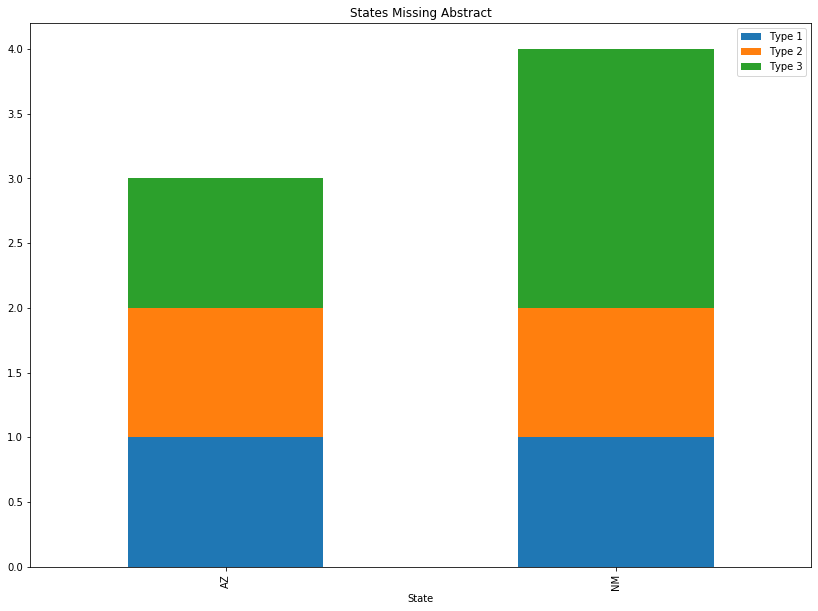

In [50]:
shredded_df.iloc[:, 1:].plot.bar(title="States Missing Abstract", stacked=True, figsize=(14, 10))
plt.xlabel('State')

## DI Direct

In [41]:
# es_url = 'https://elasticsearch-regulatory-6x-client.service.aws-ue1.consul:9200/{0}'
es_url3 = 'http://10.25.11.123:9200/{0}'
es_resource = 'landgrid_07182018/landgrid/_search'

headers = {
            'Content-Type': 'application/json',
            'Cache-Control': 'no-cache'
        }

In [19]:
url = es_url3.format(es_resource)
payload = {
  "aggregations": {
      "group_state": {
          "terms": {
              "field": "State",
              "size": 100
          },
          "aggregations": {
              "by_type": {
                  "filter": {
                      "term": { 
                          "Type": "Township"
                      }
                  }
              }
          }
      }
  },
  "size": 0
}

r = requests.get(url, headers=headers, json=payload)
print(r.encoding)
result = r.json()

UTF-8


In [25]:
by_state = result["aggregations"]["group_state"]["buckets"]
by_state[:5]

[{'key': 'TX', 'doc_count': 319137, 'by_type': {'doc_count': 249}},
 {'key': 'CA', 'doc_count': 166052, 'by_type': {'doc_count': 4931}},
 {'key': 'MT', 'doc_count': 153269, 'by_type': {'doc_count': 4407}},
 {'key': 'NM', 'doc_count': 126929, 'by_type': {'doc_count': 3607}},
 {'key': 'NV', 'doc_count': 116069, 'by_type': {'doc_count': 3455}}]

In [56]:
by_state_df = pd.DataFrame(by_state)
by_state_df.columns = ['State', 'Documents', 'by_type']

by_state_df["Townships"] = by_state_df.by_type.apply(lambda x: x['doc_count'])
by_state_df.drop(columns=["by_type"], inplace=True, axis=1)
by_state_df.set_index('State', inplace=True)
by_state_df.head()
#by_state_df.dtypes


,Documents,Townships
State,,
TX,319137,249
CA,166052,4931
MT,153269,4407
NM,126929,3607
NV,116069,3455


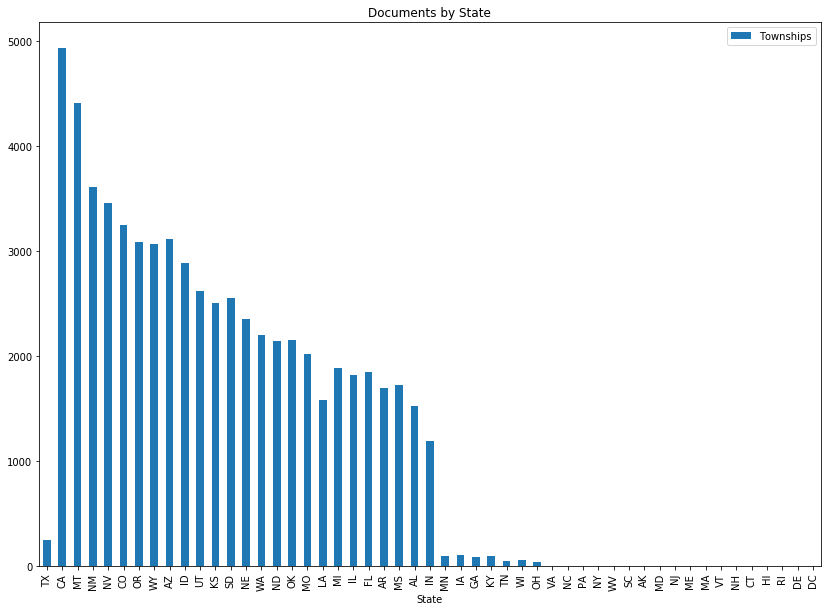

In [62]:
by_state_df.plot.bar(title="Documents by State", y='Townships', figsize=(14, 10))

## DI via Consul DNS

In [ ]:
# Need to change DNS in Docker
sess = requests.Session()
sess.headers.update(headers)

req = requests.Request('GET',
                       es_url2,
                       params=None,
                       headers=headers)

prepped_request = sess.prepare_request(req)

response = sess.send(
    prepped_request,
    stream=False,
    verify=False,
    proxies={},
    cert=None,
    timeout=None,
    allow_redirects=True)

print(response)